### Environment Setup and API Configuration

This cell loads environment variables and configures API keys for the services used in this project.

We configure:
- GROQ_API_KEY for accessing the Groq-hosted LLM
- TAVILY_API_KEY for enabling Tavily web search

This ensures secure authentication without hardcoding credentials.


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

### Initializing the Language Model

Here we initialize the LLM using ChatGroq.

This model will be used both for:
- Routing decisions
- Generating final responses after tool execution

It acts as the core reasoning engine of the routing agent.


In [2]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="openai/gpt-oss-20b")

### Initializing Knowledge Source Tools

This cell sets up multiple tools representing different knowledge sources:

- Arxiv for research papers
- Wikipedia for general knowledge
- Tavily for real-time web search

Each tool is later used by a specialized agent depending on the query type.


In [ ]:
from langchain_community.tools import TavilySearchResults
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

wiki_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki=WikipediaQueryRun(api_wrapper=wiki_wrapper)
tavily_search=TavilySearchResults(max_results=2)

C:\Users\mouli\AppData\Local\Temp\ipykernel_41820\377180316.py:10: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search=TavilySearchResults(max_results=2)


### Testing Individual Tools

Before building the agent system, we test each tool independently.

This ensures:
- The tools are properly configured
- API access is working
- The tools return valid responses

This is an important debugging and validation step.


In [4]:
arxiv.invoke("what is attention all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their mult'

In [5]:
wiki.invoke("what is agentic ai")

'Page: AI agent\nSummary: In the context of generative artificial intelligence, AI agents (also referred to as compound AI systems or agentic AI) are a class of intelligent agents distinguished by their ability to operate autonomously in complex environments. Agentic AI tools prioritize decision-makin'

In [6]:
tavily_search.invoke("what is ai agent")

[{'title': 'What are AI agents? Definition, examples, and types | Google Cloud',
  'url': 'https://cloud.google.com/discover/what-are-ai-agents',
  'content': 'What are AI agents? Definition, examples, and types | Google Cloud\n\nPage Contents\n\n   Topics\n\n   AI agents\n\nWhat is an AI agent?\n\n_Last Updated: 12/04/2025_\n\nAI agents are software systems that use AI to pursue goals and complete tasks on behalf of users. They show reasoning, planning, and memory and have a level of autonomy to make decisions, learn, and adapt. [...] Reasoning: This core cognitive process involves using logic and available information to draw conclusions, make inferences, and solve problems. AI agents with strong reasoning capabilities can analyze data, identify patterns, and make informed decisions based on evidence and context.\n   Acting: The ability to take action or perform tasks based on decisions, plans, or external input is crucial for AI agents to interact with their environment and achieve 

### Defining the Shared Graph State

This cell defines the schema for the LangGraph state.

The state includes:
- routing: which agent should handle the query
- user_input: the original user query
- output: the final generated response

This structure enables controlled data flow across the workflow.


In [ ]:
from typing import TypedDict

class GraphState(TypedDict):
    routing:str
    user_input:str
    output:str



### Tavily Agent – Web Search Specialist

This agent is responsible for handling queries related to:
- Current events
- Web-based information
- Real-time knowledge

It binds the Tavily search tool to the LLM and uses it when needed.


In [8]:
def tavily_agent(state:GraphState):
    print("--Tavily_agent--")
    response=llm.bind_tools([tavily_search]).invoke(state['user_input'])
    
    if response.tool_calls:
        tool_msg=tavily_search.invoke(response.tool_calls[0]["args"])
        final=llm.invoke(state['user_input']+tool_msg)
        return {"output":final.content}
    return {"output":response.content}
    

### Wikipedia Agent – General Knowledge Specialist

This agent handles:
- Definitions
- Concept explanations
- General informational queries

It uses Wikipedia as its primary data source.


In [9]:
def wiki_agent(state:GraphState):
    print("--Wikipedia_agent--")
    response = llm.bind_tools([wiki]).invoke(state['user_input'])
    if response.tool_calls:
        tool_msg=wiki.invoke(response.tool_calls[0]["args"])
        final=llm.invoke(state['user_input']+tool_msg)
        return {"output":final.content}
    return {"output":response.content}

### Arxiv Agent – Research Paper Specialist

This agent is responsible for:
- Research-related queries
- Academic papers
- Technical publications

It uses Arxiv as its main source of information.


In [10]:
def arxiv_agent(state:GraphState):
    print("--Arxiv_agent--")
    response= llm.bind_tools([arxiv]).invoke(state['user_input'])
    if response.tool_calls:
        tool_msg=arxiv.invoke(response.tool_calls[0]["args"])
        final=llm.invoke(state['user_input']+tool_msg)
        return {"output":final.content}
    return {"output":response.content}

### Routing Function

This function simply extracts the routing decision from the state.

It is used by LangGraph to determine which agent node should execute next.


In [11]:
def route(state:GraphState):
    return state['routing']

### Router Agent – Query Classifier and Dispatcher

This is the core routing logic of the system.

Based on the user query, the router decides:
- tavily_agent for web search queries
- wiki_agent for general knowledge queries
- arxiv_agent for research-related queries

The router returns only the name of the selected agent, enabling clean conditional routing.


In [12]:
def agent_router(state:GraphState):
    system_prompt = """
    You are a router agent.

    Decide which agent should answer the query:
    - tavily_agent → current events / web search
    - wiki_agent → general knowledge / definitions
    - arxiv_agent → research papers

    Respond with ONLY one of:
    tavily_agent, wiki_agent, arxiv_agent
    STRICT_RULES:
    1. Don't include your reasoning in the output
    2. Don't include <think>,</think> these tags in the output
    """

    response = llm.invoke([
        {"role": "system", "content": system_prompt},
        state["user_input"]
    ])

    print(response.content)

    return {"routing": response.content.strip()}

### Building the Routing Agent Workflow with LangGraph

This cell constructs the full routing workflow:

Flow:
Start → Router Agent → Selected Specialized Agent → End

LangGraph conditional edges are used to dynamically route queries to the appropriate agent based on the router’s output.


In [13]:
from langgraph.graph import StateGraph,START,END


builder=StateGraph(GraphState)

builder.add_node("tavily_agent",tavily_agent)
builder.add_node("wiki_agent",wiki_agent)
builder.add_node("arxiv_agent",arxiv_agent)
builder.add_node("agent_router",agent_router)

builder.add_edge(START,"agent_router")
builder.add_conditional_edges("agent_router",route,{
    "tavily_agent":"tavily_agent",
    "wiki_agent":"wiki_agent",
    "arxiv_agent":"arxiv_agent"
})

builder.add_edge("tavily_agent",END)
builder.add_edge("wiki_agent",END)
builder.add_edge("arxiv_agent",END)

graph=builder.compile()

### Visualizing the Routing Agent Workflow

This cell renders the internal LangGraph workflow as a diagram.

It helps visualize:
- The router node
- Conditional branching
- Execution flow

This is extremely useful for debugging and explaining agent behavior.


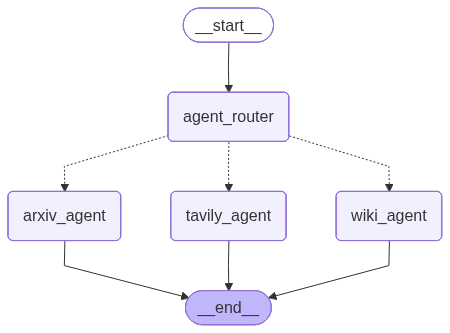

In [14]:
from IPython.display import display,Image

display(Image(graph.get_graph().draw_mermaid_png()))

### Running the Routing Agent – General Knowledge Query

This example sends a general query through the routing agent.

The router should direct it to the Wikipedia agent for handling.


In [19]:

response=graph.invoke({"user_input":"what is machine learning"})
response["output"]


wiki_agent
--Wikipedia_agent--


'**Machine learning** is a subfield of artificial intelligence (AI) that focuses on developing algorithms and statistical models that enable computers to perform tasks without being explicitly programmed for each specific task. Instead, the system learns patterns and relationships from data and uses that knowledge to make predictions, decisions, or take actions.\n\nKey points:\n\n| Aspect | What it means |\n|--------|---------------|\n| **Learning from data** | Models ingest large datasets, identify patterns, and adjust internal parameters to improve performance. |\n| **Supervised learning** | Uses labeled data (input–output pairs) to train a model to predict outputs for new inputs. |\n| **Unsupervised learning** | Finds structure or clusters in unlabeled data (e.g., grouping customers by behavior). |\n| **Reinforcement learning** | Learns by trial‑and‑error, receiving rewards or penalties for actions in an environment. |\n| **Deep learning** | A subset that uses neural networks with m

### Running the Routing Agent – Research Query

This example sends a research-related query through the routing agent.

The router should route it to the Arxiv agent for retrieving academic information.


In [16]:
response=graph.invoke({"user_input":"what is attention all you need"})
response["output"]

arxiv_agent
--Arxiv_agent--


'**Attention Is All You Need**  \n*Publication*: 2017, Proceedings of the 31st International Conference on Neural Information Processing Systems (NeurIPS)  \n*Authors*: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin  \n\n---\n\n### 1. What the paper is about  \nThe paper introduces the **Transformer**, a novel neural network architecture that relies **solely on attention mechanisms**—specifically, *self‑attention*—to model sequential data. It replaces the recurrent (RNN) and convolutional (CNN) layers that dominated sequence‑to‑sequence (seq2seq) work (e.g., machine translation) with a stack of multi‑head self‑attention and fully‑connected layers.\n\n### 2. Why it matters  \n- **Parallelization**: Self‑attention allows all tokens in a sequence to be processed simultaneously, vastly speeding up training on GPUs/TPUs compared to sequential RNNs.  \n- **Long‑range dependencies**: Attention directly connects any two 